## Import's

In [1]:
import pandas as pd
import sqlite3

## Подключение к БД

In [2]:
conn = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)

,name
0,pageviews
1,checker
2,deadlines


In [4]:
schema = pd.read_sql("PRAGMA table_info(pageviews);", conn)
schema

,cid,name,type,notnull,dflt_value,pk
0,0,index,INTEGER,0,None,0
1,1,uid,TEXT,0,None,0
2,2,datetime,TIMESTAMP,0,None,0


## Забираем коммиты пользователей

In [6]:
query = '''
SELECT
    uid,
    timestamp
FROM checker
WHERE uid LIKE 'user_%'
'''

df = pd.read_sql(query, conn)

In [7]:
df.head()

,uid,timestamp
0,user_4,2020-04-17 05:19:02.744528
1,user_4,2020-04-17 05:22:35.249331
2,user_4,2020-04-17 05:22:45.549397
3,user_4,2020-04-17 05:34:14.691200
4,user_4,2020-04-17 05:34:24.422370


## Преобразования даты и добавление меток(ночь, утро, день, вечер)

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

def get_period(hour):
    if 0 <= hour < 4:
        return 'night'
    elif 4 <= hour < 10:
        return 'morning'
    elif 10 <= hour < 17:
        return 'afternoon'
    else:
        return 'evening'

df['period'] = df['hour'].apply(get_period)


In [13]:
df.head()

,uid,timestamp,date,hour,period
0,user_4,2020-04-17 05:19:02.744528,2020-04-17,5,morning
1,user_4,2020-04-17 05:22:35.249331,2020-04-17,5,morning
2,user_4,2020-04-17 05:22:45.549397,2020-04-17,5,morning
3,user_4,2020-04-17 05:34:14.691200,2020-04-17,5,morning
4,user_4,2020-04-17 05:34:24.422370,2020-04-17,5,morning


## Подсчёт коммитов по дням и периодам

In [9]:
commits_by_period = df.groupby(['date', 'period']).size().unstack(fill_value=0)

ordered_periods = ['night', 'morning', 'afternoon', 'evening']
commits_by_period = commits_by_period[ordered_periods]

commits_by_period.head()

period,night,morning,afternoon,evening
date,,,,
2020-04-17,0,13,10,0
2020-04-18,0,1,33,35
2020-04-19,2,4,16,11
2020-04-20,0,0,12,13
2020-04-21,0,0,0,25


In [10]:
commits_by_period.count()

period
night        35
morning      35
afternoon    35
evening      35
dtype: int64

## Построение графика

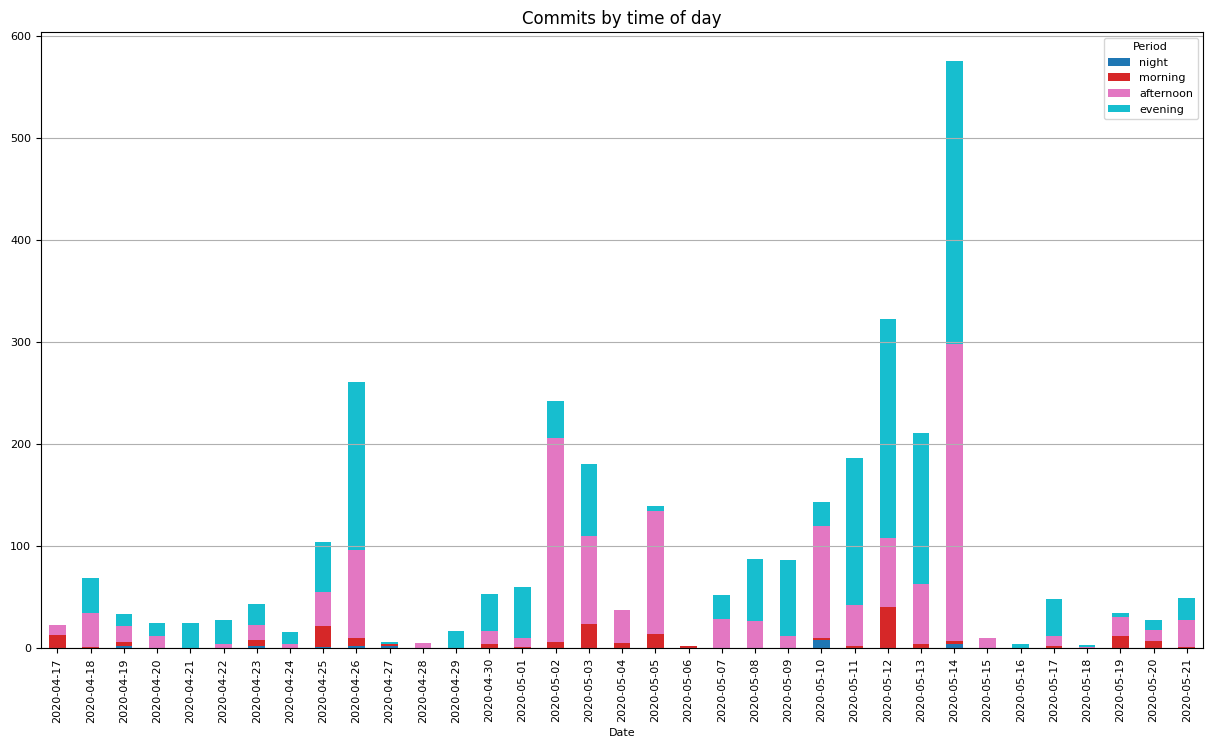

In [11]:
ax = commits_by_period.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 8),
    fontsize=8,
    title='Commits by time of day',
    colormap='tab10'
)

ax.set_xlabel('Date', fontsize=8)
ax.legend(title='Period', fontsize=8, title_fontsize=8, loc='upper right')
ax.grid(axis='y', visible=True)


## Закрываем соединение с БД

In [12]:
conn.close()

## **When do our users usually commit the labs: in the night, morning, afternoon, or evening?**

Ответ: **afternoon** and **evening**

**Which day has the most number of commits and at the same time the number of commits in the evening is higher than in the afternoon?**

Ответ: **2020-05-12**

In [13]:
df['period'].value_counts().head(2)

period
evening      1611
afternoon    1391
Name: count, dtype: int64

In [14]:
commits_by_period['total'] = commits_by_period.sum(axis=1)
filtered = commits_by_period[commits_by_period['evening'] > commits_by_period['afternoon']]
day_answer = filtered['total'].idxmax()
day_answer


datetime.date(2020, 5, 12)